# QB synchronization index
## exploratory analysis

import basic stuff and load NINO3.4 data

we will work with monthly *anomalised* **NINO3.4** index between **1900/1/1 and 2014/12/31**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap('summer')
%matplotlib inline
from datetime import date, datetime
import sys
sys.path.append('/Users/nikola/work-ui/multi-scale')
from src.data_class import DataField, load_enso_index, load_station_data
import itertools as it
from scipy.signal import argrelextrema

In [2]:
enso = load_enso_index("../../data/nino34raw.txt", '3.4', date(1900, 1, 1), date(2015, 1, 1), anom = True)

** loaded
** anomalising
[2017-01-12 16:49:27.996057] Nino3.4 data loaded with shape (1380,). Date range is 1/1900 - 12/2014 inclusive.


below is function for rendering *El Nino* and *La Nina* events

light colours are for moderate events, darker colours are for strong / very strong events; 

[reference](http://ggweather.com/enso/oni.htm) - based on **ONI** index

In [3]:
def plot_enso_episodes(min, max):
    nino_strong = [1957, 1965, 1972, 1982, 1997, 2015]
    for y in nino_strong:
        start = enso.find_date_ndx(date(y, 9, 1))
        end = enso.find_date_ndx(date(y+1, 5, 1))
        if start is None and end is not None:
            start = 0
        if end is None and start is not None:
            end = enso.data.shape[0]
        if start is None and end is None:
            continue
        x = np.arange(start, end, 1)
        plt.fill_between(x, min, max, facecolor = "#F83F67", edgecolor = "#F83F67", alpha = 0.7)

    nino_moderate = [1963, 1986, 1987, 1991, 2002, 2009]
    for y in nino_moderate:
        start = enso.find_date_ndx(date(y, 9, 1))
        end = enso.find_date_ndx(date(y+1, 5, 1))
        if start is None and end is not None:
            start = 0
        if end is None and start is not None:
            end = enso.data.shape[0]
        if start is None and end is None:
            continue
        x = np.arange(start, end, 1)
        plt.fill_between(x, min, max, facecolor = "#F83F67", edgecolor = "#F83F67", alpha = 0.3)

    nina_strong = [1973, 1975, 1988]
    for y in nina_strong:
        start = enso.find_date_ndx(date(y, 9, 1))
        end = enso.find_date_ndx(date(y+1, 5, 1))
        if start is None and end is not None:
            start = 0
        if end is None and start is not None:
            end = enso.data.shape[0]
        if start is None and end is None:
            continue
        x = np.arange(start, end, 1)
        plt.fill_between(x, min, max, facecolor = "#30AEDF", edgecolor = "#30AEDF", alpha = 0.7)
    
    nina_moderate = [1955, 1970, 1998, 1999, 2007, 2010]
    for y in nina_moderate:
        start = enso.find_date_ndx(date(y, 9, 1))
        end = enso.find_date_ndx(date(y+1, 5, 1))
        if start is None and end is not None:
            start = 0
        if end is None and start is not None:
            end = enso.data.shape[0]
        if start is None and end is None:
            continue
        x = np.arange(start, end, 1)
        plt.fill_between(x, min, max, facecolor = "#30AEDF", edgecolor = "#30AEDF", alpha = 0.3)

below are functions for extracting the phase, continuous phase and amplitude

in this notebook I will work with periods of **20**, **22**, **24** and **26** months, hence *4 QB cycles*

In [4]:
def get_continuous_phase(ph):
    phase = ph.copy()
    for i in range(phase.shape[0] - 1):
        if np.abs(phase[i+1] - phase[i]) > 1:
            phase[i+1:] += 2*np.pi
            
    return phase

def get_cycles_and_phases(periods):
    cycles = []
    phases = []
    cont_phases = []
    for period in periods:
        enso.wavelet(period, period_unit = 'm', cut = 12)
        enso.amplitude = enso.amplitude[ndx[12:-12]]
        enso.phase = enso.phase[ndx[12:-12]]
        cycles.append(enso.amplitude * np.cos(enso.phase))
        phases.append(enso.phase)
        cont_phases.append(get_continuous_phase(enso.phase))
    return cycles, phases, cont_phases

PERIODS = [i for i in range(20,27,2)]
# PERIODS = [24, 26]
colors = [cmap(f) for f in np.linspace(0, 1, len(PERIODS))]
ndx = enso.select_date(date(1950, 1, 1), date(2010, 1, 1), apply_to_data = False)
cycles, phases, cont_phases = get_cycles_and_phases(PERIODS)

enso.wavelet(12, period_unit = 'm', cut = 12)
enso.amplitude = enso.amplitude[ndx[12:-12]]
enso.phase = enso.phase[ndx[12:-12]]
enso_ann = enso.amplitude * np.cos(enso.phase)

enso.data = enso.data[ndx]
enso.time = enso.time[ndx]

/Users/nikola/work-ui/multi-scale/src/wavelet_analysis.py:139: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  k_minus = -k[np.fix(n-1)/2 - 1::-1]


## 1. method - continuous differences

* for each time point
    * for each pair of continuous phases
        * translate to joint minimum, so they are intersecting at time *t*
        * compute average difference between the phases in the range *t - points* : *t + points* including
* return average over all pairs as the **synchronization measure**

**minimum** in this measure would signify synchronization; better visible if taking natural logarithm

In [5]:
def get_differences(list_phases, points = 3):
    import copy
    cont_phases = copy.deepcopy(list_phases)
    pairs = list(it.combinations(cont_phases, 2))
    avg_diff = np.zeros((len(pairs), cont_phases[0].shape[0],))
    for t in range(cont_phases[0].shape[0]):
        for cnt, pair in zip(range(len(pairs)), pairs):
            joint_min = np.amin([pair[0][t], pair[1][t]])
            # translate all to joint minimum
            for ph in pair:
                ph -= (ph[t] - joint_min)
            # compute avg diff over points
            avg_diff[cnt, t] = np.mean(np.abs(pair[0][max(t - points, 0) : min(t + points + 1, cont_phases[0].shape[0])] - pair[1][max(t - points, 0) : min(t + points + 1, cont_phases[0].shape[0])]))

    return np.mean(avg_diff, axis = 0)

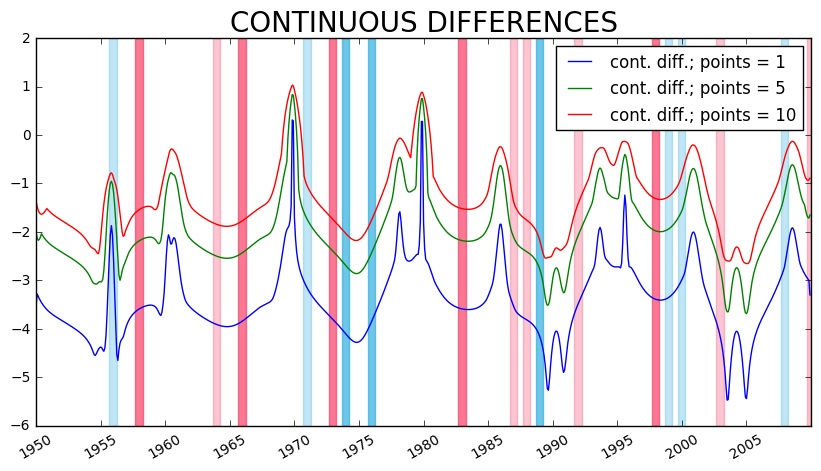

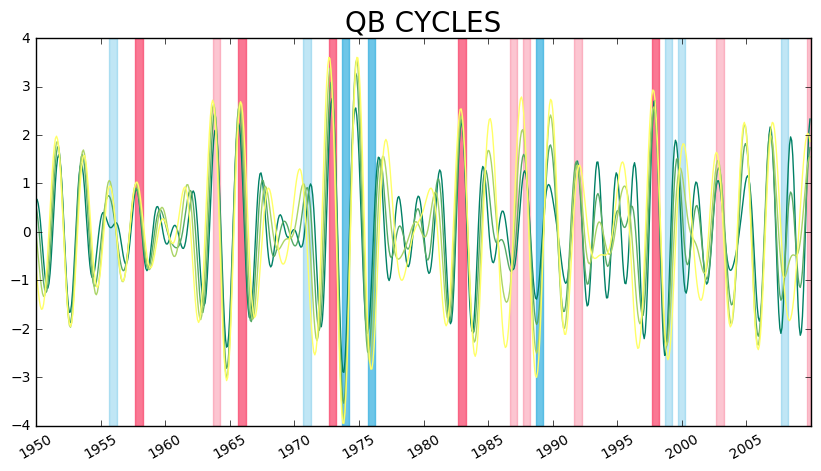

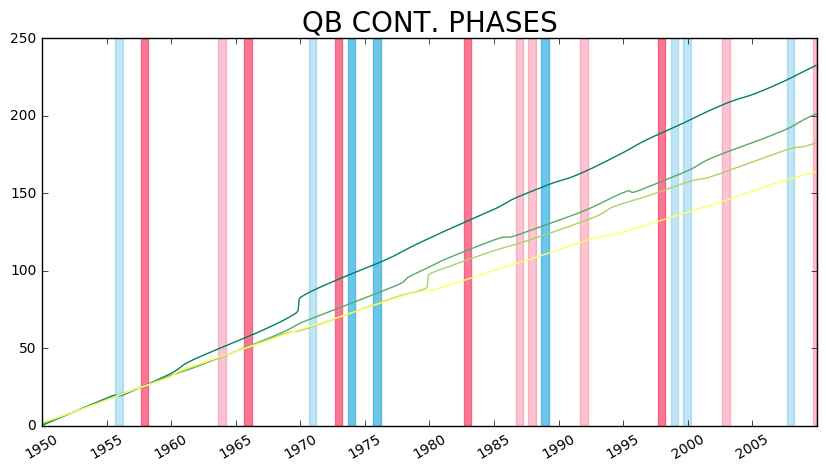

In [6]:
TO = enso.get_date_from_ndx(-1).year
FROM = enso.get_date_from_ndx(0).year

diff1 = np.log(get_differences(cont_phases, 1))
diff2 = np.log(get_differences(cont_phases, 5))
diff3 = np.log(get_differences(cont_phases, 10))

# minima = argrelextrema(diff3, np.less, order = 5)[0]

plt.figure(figsize=(10,5))
plt.plot(diff1, label = "cont. diff.; points = 1")
plt.plot(diff2, label = "cont. diff.; points = 5")
plt.plot(diff3, label = "cont. diff.; points = 10")
# for mi in minima:
#     plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
# plt.ylim([0, 1.5])
plot_enso_episodes(-6, 2)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.legend()
plt.title("CONTINUOUS DIFFERENCES", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for cyc, col in zip(cycles, colors):
    plt.plot(cyc, color = col, linewidth = 1)
# for mi in minima:
#     plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plt.xlim([0, enso.data.shape[0]])
plot_enso_episodes(-4, 4)
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
# plt.legend()
plt.title("QB CYCLES", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for ph, col in zip(cont_phases, colors):
    plt.plot(ph, color = col, linewidth = 1)
# for mi in minima:
#     plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plt.xlim([0, enso.data.shape[0]])
plot_enso_episodes(0, 250)
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
# plt.legend()
plt.title("QB CONT. PHASES", size = 20)
plt.show()

## 2. method - circular differences

* for each time point
    * for each pair of circular (defined on $[0, 2\pi]$) phases
        * compute weighted average difference between the phases in the range *t - points* : *t + points* including
        * weights are linear, triangle shaped, with maximum of 1 at time *t*, decreasing linearly to 0
* return average over all pairs as the **synchronization measure**

**minimum** in this measure would signify synchronization; better visible if taking natural logarithm

In [7]:
def pascal(n):
    line = [1]
    for k in range(n):
        line.append(line[k] * (n-k) / (k+1))
    return line


def get_differences2(list_phases, points = 3):
    import copy
    phases = copy.deepcopy(list_phases)
    pairs = list(it.combinations(phases, 2))
    avg_diff = np.zeros((len(pairs), cont_phases[0].shape[0],))
    weights = np.concatenate([ np.linspace(0,1,points+2), np.linspace(0,1,points+1, endpoint = False)[::-1] ])[1:-1]
    for t in range(cont_phases[0].shape[0]):
        for cnt, pair in zip(range(len(pairs)), pairs):
            arg = np.abs(pair[0][max(t - points, 0) : min(t + points + 1, cont_phases[0].shape[0])] - 
                                                 pair[1][max(t - points, 0) : min(t + points + 1, cont_phases[0].shape[0])])
            avg_diff[cnt, t] = np.average(arg, weights = weights[:arg.shape[0]])
#                                          weights = np.array(pascal(points*2)))

    return np.mean(avg_diff, axis = 0)

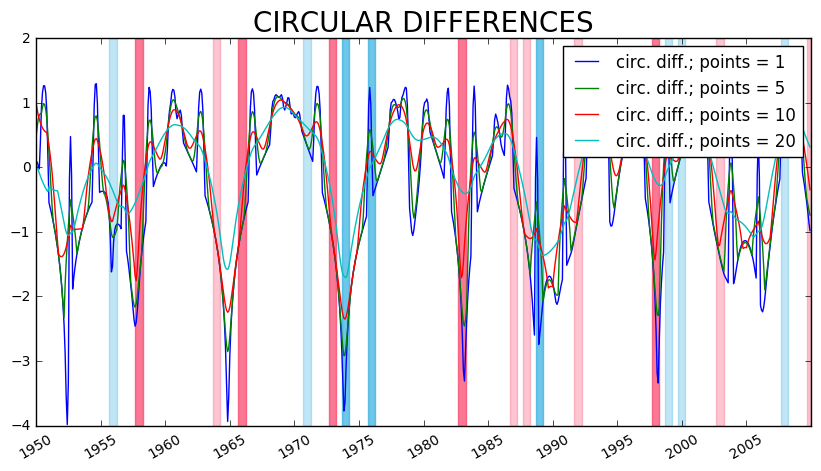

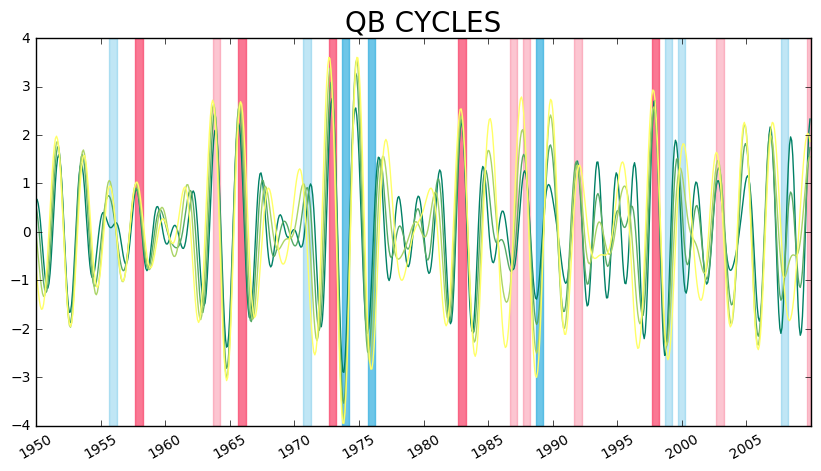

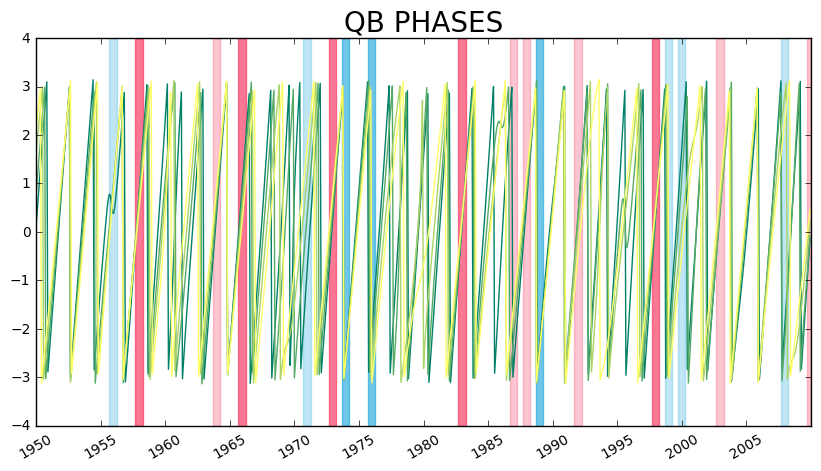

In [8]:
diff1 = np.log(get_differences2(phases, 1))
diff2 = np.log(get_differences2(phases, 5))
diff3 = np.log(get_differences2(phases, 10))
diff4 = np.log(get_differences2(phases, 20))

minima = argrelextrema(diff1, np.less)[0]

plt.figure(figsize=(10,5))
plt.plot(diff1, label = "circ. diff.; points = 1")
plt.plot(diff2, label = "circ. diff.; points = 5")
plt.plot(diff3, label = "circ. diff.; points = 10")
plt.plot(diff4, label = "circ. diff.; points = 20")
plot_enso_episodes(-4, 2)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.legend()
plt.title("CIRCULAR DIFFERENCES", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for cyc, col in zip(cycles, colors):
    plt.plot(cyc, color = col, linewidth = 1)
# plt.plot(enso.data, color = 'k', linewidth = 2)
# plt.plot(enso_ann, color = 'red', linewidth = 1)
# for mi in minima:
#     if diff1[mi] < -1:
#         plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plot_enso_episodes(-4, 4)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.title("QB CYCLES", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for ph, col in zip(phases, colors):
    plt.plot(ph, color = col, linewidth = 1)
# for mi in minima:
#     if diff1[mi] < -1:
#         plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plot_enso_episodes(-4, 4)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.title("QB PHASES", size = 20)
plt.show()

## 3. method - mean phase coherence

* for each time point
    * for each pair of continuous phases
        * compute MPC between the phases in the range *t - points* : *t + points* including as $\langle\cos\phi_{1,1}\rangle^{2} + \langle\sin\phi_{1,1}\rangle^{2}$, where $\langle\rangle$ denotes time average and $\phi_{1,1}$ is one:one difference between phases, modulo $2\pi$
* return average over all pairs as the **synchronization measure**

**maximum** in this measure would signify synchronization

In [9]:
def get_mpc(list_phases, points = 3):
    import copy
    phases = copy.deepcopy(list_phases)
    pairs = list(it.combinations(phases, 2))
    avg_diff = np.zeros((len(pairs), cont_phases[0].shape[0],))
    for t in range(phases[0].shape[0]):
        for cnt, pair in zip(range(len(pairs)), pairs):
            diff = pair[1][max(t - points, 0) : min(t + points + 1, pair[1].shape[0])] - pair[0][max(t - points, 0) : min(t + points + 1, pair[0].shape[0])]
            diff = np.mod(diff, 2*np.pi)
            avg_diff[cnt, t] = np.power(np.mean(np.cos(diff)), 2) + np.power(np.mean(np.sin(diff)), 2)

    return np.mean(avg_diff, axis = 0)

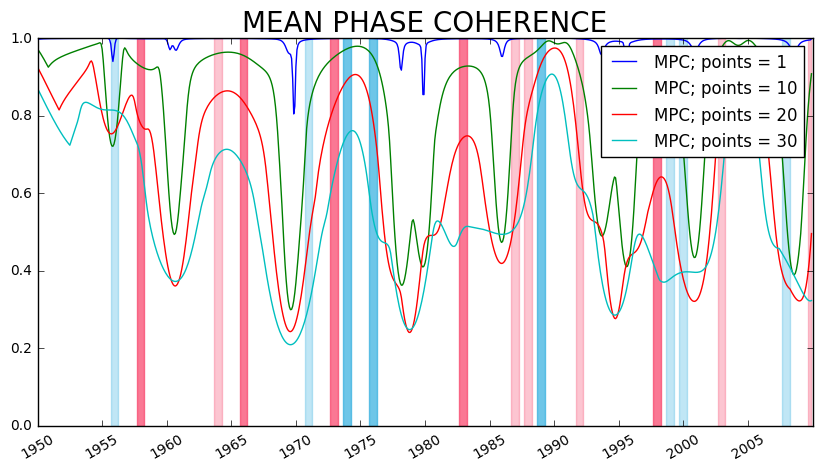

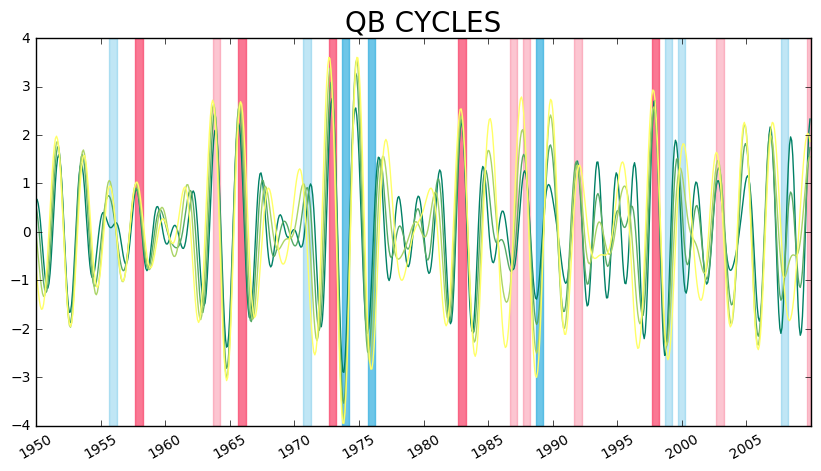

In [10]:
diff1 = get_mpc(cont_phases, 1)
diff2 = get_mpc(cont_phases, 10)
diff3 = get_mpc(cont_phases, 20)
diff4 = get_mpc(cont_phases, 30)

# minima = argrelextrema(diff1, np.less)[0]

plt.figure(figsize=(10,5))
plt.plot(diff1, label = "MPC; points = 1")
plt.plot(diff2, label = "MPC; points = 10")
plt.plot(diff3, label = "MPC; points = 20")
plt.plot(diff4, label = "MPC; points = 30")
plot_enso_episodes(0, 1)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.legend()
plt.title("MEAN PHASE COHERENCE", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for cyc, col in zip(cycles, colors):
    plt.plot(cyc, color = col, linewidth = 1)
# plt.plot(enso.data, color = 'k', linewidth = 2)
# plt.plot(enso_ann, color = 'red', linewidth = 1)
# for mi in minima:
#     if diff1[mi] < -1:
#         plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plot_enso_episodes(-4, 4)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.title("QB CYCLES", size = 20)
plt.show()

## 4. method - synch. index based on Shannon entropy
(taken from [Phase synchronization: from theory to data analysis](http://www.stat.physik.uni-potsdam.de/~mros/Moss_book.pdf))

* for each time point
    * for each pair of continuous phases
        * compute entropy index between the phases in the range *t - points* : *t + points* including
* return average over all pairs as the **synchronization measure**

entropy index is computed as $\rho_{n,m} = S_{max} - S / S_{max}$, where $S_{max} = \ln{N}$ and $S = -\sum\limits_{k=1}^{N}p_{k}\ln{p_{k}}$, all this is computed on $\psi_{1,1}$, which is distribution of phase difference $\phi_{n,m}\mod 2\pi$ and finally, $N$ is number of bins to which we equidistantly divide the interval

**remark** - bins should be, of course, defined on interval $[0,1]$ by division to $N$ bins; nevertheless, I'm able to get much better results when I actually divide the $[\min(\psi_{n,m}), \max(\psi_{n,m})]$ interval into $N$ bins 

**maximum** in this measure would signify synchronization

In [11]:
def synch_index_entropy(phase1, phase2, n, m, bins = 16):
    ph1 = phase1.copy()
    ph2 = phase2.copy()
    ph1 /= 2*np.pi
    ph2 /= 2*np.pi
    
    diff = n*ph1 - m*ph2

    phi = np.mod(diff, 1)
    
    S_max = np.log(bins)
#     bins_array = np.linspace(0, 1, bins+1)
    bins_array = np.linspace(phi.min(), phi.max(), bins+1)
#     print phi.min(), phi.max()
    S = 0
    for i in range(bins):
        ndx = (phi <= bins_array[i+1]) & (phi >= bins_array[i])
        pk = np.sum(ndx) / float(phi.shape[0])
        if pk != 0:
            S -= pk * np.log(pk)
    return (S_max - S) / S_max


def get_entropy_synch_index(list_phases, points = 3, bins = 8):
    import copy
    phases = copy.deepcopy(list_phases)
    pairs = list(it.combinations(phases, 2))
    avg_diff = np.zeros((len(pairs), cont_phases[0].shape[0],))
    for t in range(phases[0].shape[0]):
        for cnt, pair in zip(range(len(pairs)), pairs):
            avg_diff[cnt, t] = synch_index_entropy(pair[0][max(t - points,0) : min(t + points + 1, pair[0].shape[0])], pair[1][max(t - points,0) : min(t + points + 1, pair[1].shape[0])], 1, 1, bins = bins)

    return np.mean(avg_diff, axis = 0)

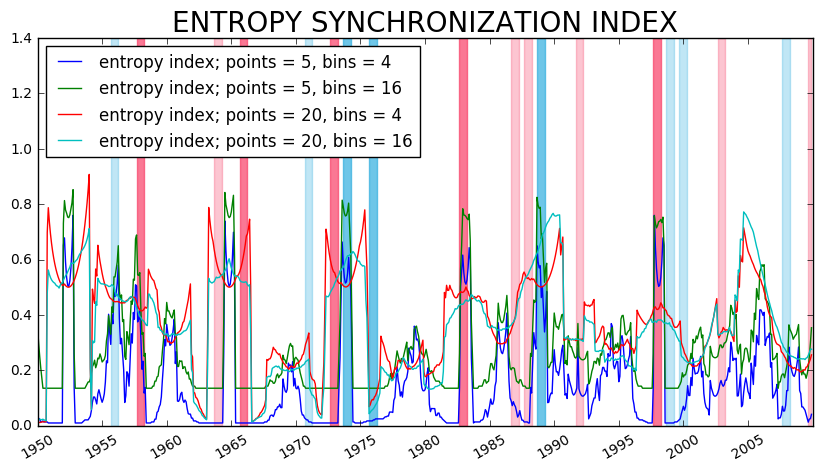

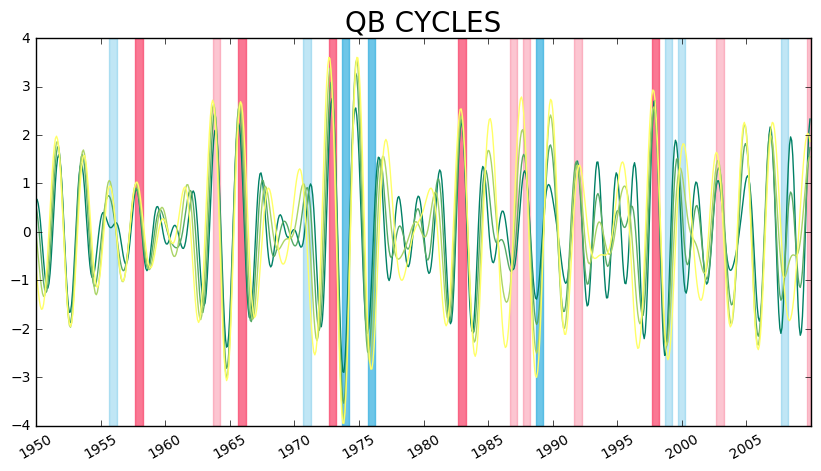

In [12]:
diff1 = get_entropy_synch_index(cont_phases, points = 20, bins = 16)
diff2 = get_entropy_synch_index(cont_phases, points = 5, bins = 4)
diff3 = get_entropy_synch_index(cont_phases, points = 5, bins = 16)
diff4 = get_entropy_synch_index(cont_phases, points = 20, bins = 4)

# minima = argrelextrema(diff1, np.less)[0]

plt.figure(figsize=(10,5))
plt.plot(diff2, label = "entropy index; points = 5, bins = 4")
plt.plot(diff3, label = "entropy index; points = 5, bins = 16")
plt.plot(diff4, label = "entropy index; points = 20, bins = 4")
plt.plot(diff1, label = "entropy index; points = 20, bins = 16")
plot_enso_episodes(0, 1.4)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.legend(loc = "upper left")
plt.title("ENTROPY SYNCHRONIZATION INDEX", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for cyc, col in zip(cycles, colors):
    plt.plot(cyc, color = col, linewidth = 1)
# plt.plot(enso.data, color = 'k', linewidth = 2)
# plt.plot(enso_ann, color = 'red', linewidth = 1)
# for mi in minima:
#     if diff1[mi] < -1:
#         plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plot_enso_episodes(-4, 4)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.title("QB CYCLES", size = 20)
plt.show()

## 5. method - circular variance
(taken from [Phase synchronization: from theory to data analysis](http://www.stat.physik.uni-potsdam.de/~mros/Moss_book.pdf))

* for each time point
    * for each pair of continuous phases
        * compute $\mathrm{e}^{i\phi_{1,1}}$, where $\phi_{1,1}$ is $1:1$ difference between the phases in the range *t - points* : *t + points* including
* return average over all pairs as the **synchronization measure**

**maximum** in this measure would signify synchronization

In [13]:
def get_synch_index(list_phases, points = 3):
    import copy
    phases = copy.deepcopy(list_phases)
    pairs = list(it.combinations(phases, 2))
    avg_diff = np.zeros((len(pairs), cont_phases[0].shape[0],))
    for t in range(phases[0].shape[0]):
        for cnt, pair in zip(range(len(pairs)), pairs):
            avg_diff[cnt, t] = np.mean(np.exp(1j*np.abs(pair[0][max(t - points,0) : min(t + points + 1, pair[0].shape[0])] - pair[1][max(t - points,0) : min(t + points + 1, pair[1].shape[0])])))

    return np.mean(avg_diff, axis = 0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


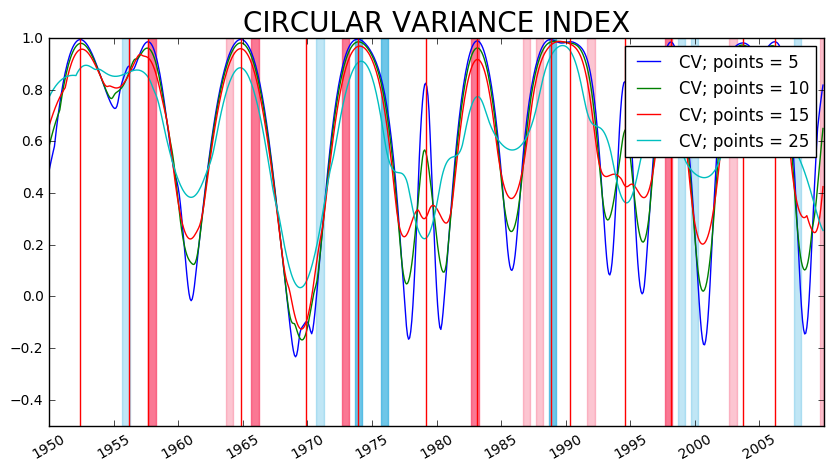

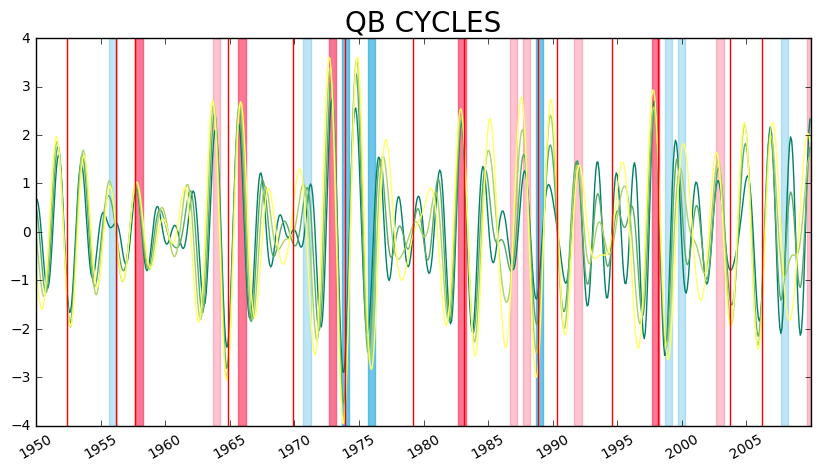

In [14]:
diff1 = get_synch_index(cont_phases, points = 5)
diff2 = get_synch_index(cont_phases, points = 10)
diff3 = get_synch_index(cont_phases, points = 15)
diff4 = get_synch_index(cont_phases, points = 25)

minima = argrelextrema(diff1, np.greater, order = 5)[0]

plt.figure(figsize=(10,5))
plt.plot(diff1, label = "CV; points = 5")
plt.plot(diff2, label = "CV; points = 10")
plt.plot(diff3, label = "CV; points = 15")
plt.plot(diff4, label = "CV; points = 25")
plot_enso_episodes(-0.5, 1)
for mi in minima:
    plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plt.ylim([-0.5,1])
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.legend()
plt.title("CIRCULAR VARIANCE INDEX", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for cyc, col in zip(cycles, colors):
    plt.plot(cyc, color = col, linewidth = 1)
# plt.plot(enso.data, color = 'k', linewidth = 2)
# plt.plot(enso_ann, color = 'red', linewidth = 1)
for mi in minima:
    plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plot_enso_episodes(-4, 4)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.title("QB CYCLES", size = 20)
plt.show()

## 6. method - index based on conditional distribution
(taken from [Phase synchronization: from theory to data analysis](http://www.stat.physik.uni-potsdam.de/~mros/Moss_book.pdf))

* for each time point
    * for each pair of continuous phases
        * compute conditional distribution based on stroboscopic approach between the phases in the range *t - points* : *t + points* including
* return average over all pairs as the **synchronization measure**

synchronization index is computed as follows:
* wrap phases to intervals $[0, 2\pi m]$ and $[0, 2\pi n]$ respectively to detect $n:m$ phase synchronization
* divide $[0, 2\pi m]$ interval into $N$ bins
* for each bin compute $\Lambda_{l} = \langle \exp\left[ i(\eta_{l}/n) \right] \rangle$, where $\langle\rangle$ denotes mean over points of $\varphi_{1}$ in particular bin and $\eta_{l} = \varphi_{2}\mod 2\pi n |_{\varphi_{1}\mod 2\pi m = \theta} $

**maximum** in this measure would signify synchronization

In [15]:
def synch_index_strobo(phase1, phase2, n, m, no_bins = 4):
    ph1 = phase1.copy()
    ph2 = phase2.copy()
    
    ph1 = np.mod(ph1, 2*np.pi*m)
    ph2 = np.mod(ph2, 2*np.pi*n)

    lambda_bins = np.zeros((no_bins,))
    
    bins = np.linspace(0, 2*np.pi*m, no_bins + 1)
    for i in range(no_bins):
        ndx = (ph1 >= bins[i]) & (ph1 <= bins[i+1])
        lambda_bins[i] = np.nanmean([ np.exp(1j*(ph2[t] / float(n))) for t in np.where(ndx == True)[0]])
        
    return np.nanmean(np.abs(lambda_bins))

def get_strobo_synch_index(list_phases, points = 3, bins = 8):
    import copy
    phases = copy.deepcopy(list_phases)
    pairs = list(it.combinations(phases, 2))
    avg_diff = np.zeros((len(pairs), cont_phases[0].shape[0],))
    for t in range(phases[0].shape[0]):
        for cnt, pair in zip(range(len(pairs)), pairs):
            avg_diff[cnt, t] = synch_index_strobo(pair[0][max(t - points,0) : min(t + points + 1, pair[0].shape[0])], pair[1][max(t - points,0) : min(t + points + 1, pair[1].shape[0])], 1, 1, no_bins = bins)

    return np.mean(avg_diff, axis = 0)

        

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


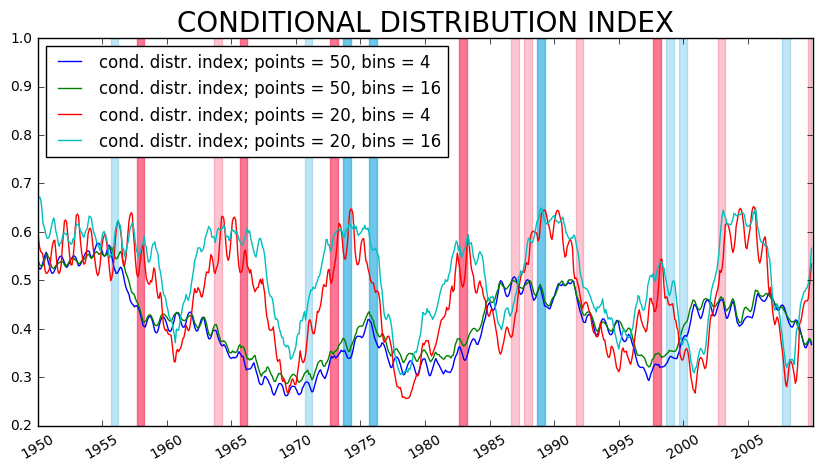

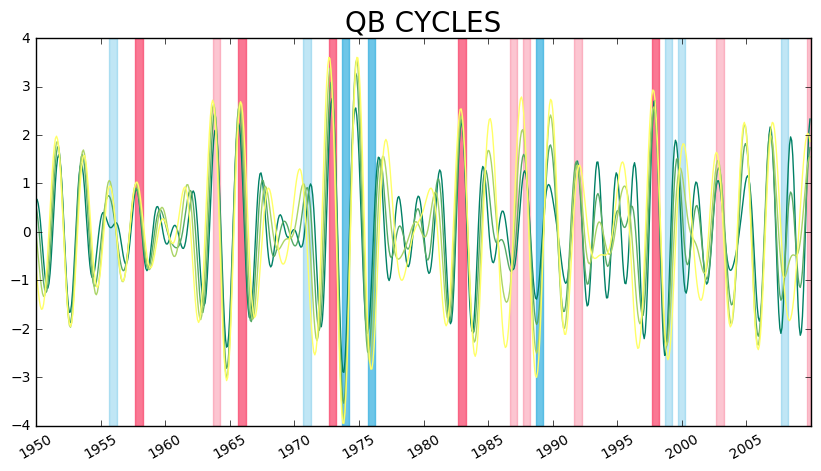

In [16]:
diff1 = get_strobo_synch_index(cont_phases, points = 20, bins = 16)
diff2 = get_strobo_synch_index(cont_phases, points = 50, bins = 4)
diff3 = get_strobo_synch_index(cont_phases, points = 50, bins = 16)
diff4 = get_strobo_synch_index(cont_phases, points = 20, bins = 4)

# minima = argrelextrema(diff1, np.less)[0]

plt.figure(figsize=(10,5))
plt.plot(diff2, label = "cond. distr. index; points = 50, bins = 4")
plt.plot(diff3, label = "cond. distr. index; points = 50, bins = 16")
plt.plot(diff4, label = "cond. distr. index; points = 20, bins = 4")
plt.plot(diff1, label = "cond. distr. index; points = 20, bins = 16")
plot_enso_episodes(0.2, 1)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.legend(loc = "upper left")
plt.title("CONDITIONAL DISTRIBUTION INDEX", size = 20)
plt.show()

plt.figure(figsize=(10,5))
for cyc, col in zip(cycles, colors):
    plt.plot(cyc, color = col, linewidth = 1)
# plt.plot(enso.data, color = 'k', linewidth = 2)
# plt.plot(enso_ann, color = 'red', linewidth = 1)
# for mi in minima:
#     if diff1[mi] < -1:
#         plt.axvline(mi, 0, 1, linewidth = 1, color = "red")
plot_enso_episodes(-4, 4)
plt.xlim([0, enso.data.shape[0]])
plt.xticks(np.arange(0, enso.data.shape[0]+1, ((TO-FROM)/10)*12), np.arange(FROM, TO+1, (TO-FROM)/10), rotation = 30)
plt.title("QB CYCLES", size = 20)
plt.show()